## Skin Cancer Classification Transfer Learning ResNet50

In [9]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

In [ ]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

print(os.listdir(base))

['NV', 'DF', 'AKIEC', 'MEL', 'BKL', 'VASC', 'BCC']


In [ ]:
for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    os.remove('HAM_images/'+image)

for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    print(image)

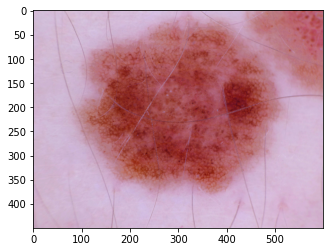

(450, 600, 3)


In [ ]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [17]:
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}

df_labels = pd.read_csv("ISIC2018GroundTruth.csv")
for i in range(len(df_labels)):
    labels = df_labels.iloc[i,1:]
    df_labels.loc[i,"label"] = mapping[list(labels).index(1)]

#df_labels["label"]=df_labels["label"].astype(int)
df_labels.set_index('image', inplace=True)

df_labels.head()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
image,,,,,,,,
ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


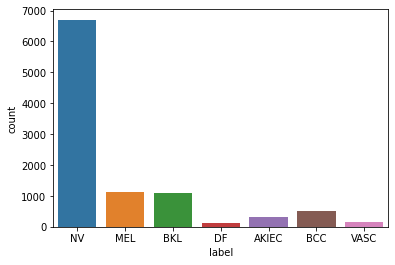

In [18]:
sns.countplot(df_labels["label"])
plt.show()

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
                                                  y=df_labels["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [ ]:
from tqdm import tqdm

images = os.listdir('HAM_images')

for image in tqdm(images):
    fname=image[:-4]
    label=df_labels.loc[fname, "label"]
    src = os.path.join('HAM_images', image)
    dst = os.path.join('HAM_Dataset', label, image)
    shutil.copyfile(src, dst)

100%|██████████| 10015/10015 [00:39<00:00, 253.53it/s]


### Train Test Split

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

In [57]:
data_dir = 'HAM_Dataset'
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


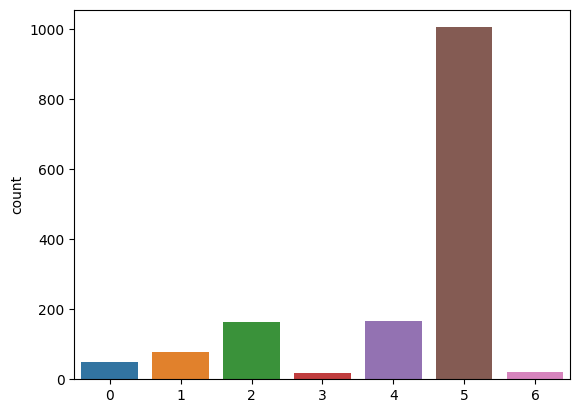

In [58]:
sns.countplot(x=test_image_gen.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


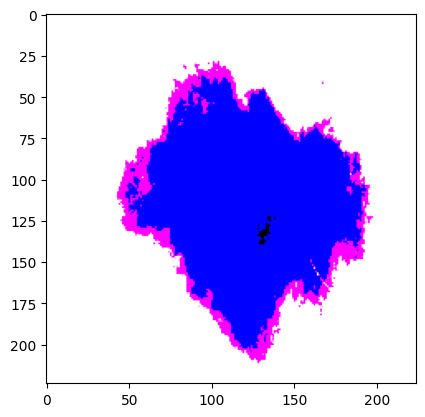

In [59]:
plt.imshow(train_image_gen[0][0][0])

##     

## Transfer Learning using ResNet50 Model

In [1]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [62]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Model Training

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('model_vgg.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [2]:
history = tl_model.fit(train_image_gen,
                    epochs=15, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)


Epoch 1/15
134/134 [==============================] - 362s 2s/step - loss: 5.6704 - accuracy: 0.5337 - val_loss: 5.3744 - val_accuracy: 0.7338

Epoch 00001: val_accuracy improved from -inf to 0.73382, saving model to model_vgg.hdf5
Epoch 2/15
134/134 [==============================] - 256s 2s/step - loss: 4.7171 - accuracy: 0.6538 - val_loss: 4.3163 - val_accuracy: 0.7832

Epoch 00002: val_accuracy improved from 0.73382 to 0.78319, saving model to model_vgg.hdf5
Epoch 3/15
134/134 [==============================] - 257s 2s/step - loss: 4.1003 - accuracy: 0.7189 - val_loss: 3.9572 - val_accuracy: 0.7765

Epoch 00003: val_accuracy did not improve from 0.78319
Epoch 4/15
134/134 [==============================] - 256s 2s/step - loss: 3.6505 - accuracy: 0.7478 - val_loss: 3.6758 - val_accuracy: 0.7398

Epoch 00004: val_accuracy did not improve from 0.78319

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/15
134/134 [==============================] -

### Model Evaluation

In [ ]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist.csv')

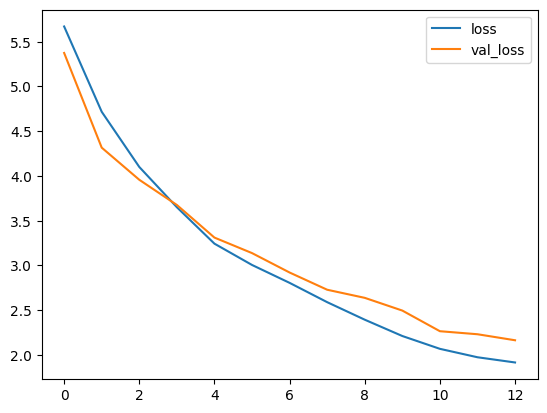

In [65]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

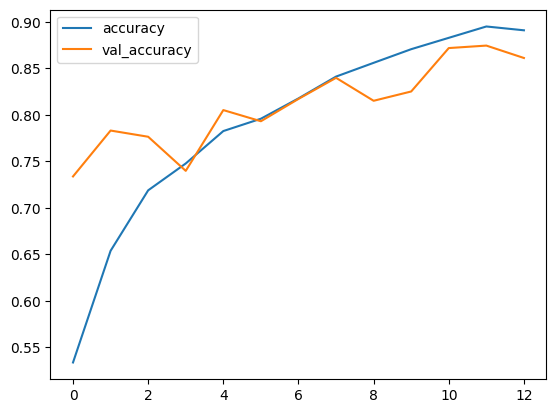

In [66]:
metrics[["accuracy","val_accuracy"]].plot()

In [38]:
tl_model.evaluate(test_image_gen)

47/47 [==============================] - 33s 701ms/step - loss: 0.6979 - accuracy: 0.8659


[0.6978632807731628, 0.8659105896949768]

In [67]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

24/24 [==============================] - 29s 1s/step


In [68]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix


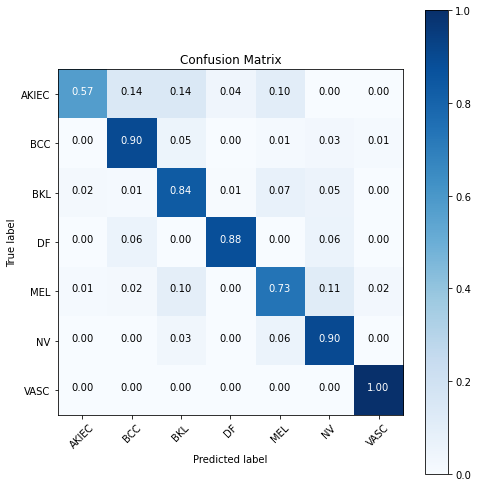

In [19]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(test_image_gen.class_indices.keys())
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [72]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.57      0.67        49
           1       0.81      0.90      0.85        77
           2       0.69      0.84      0.76       164
           3       0.79      0.88      0.83        17
           4       0.61      0.73      0.66       166
           5       0.97      0.90      0.93      1005
           6       0.81      1.00      0.89        21

    accuracy                           0.87      1499
   macro avg       0.79      0.83      0.80      1499
weighted avg       0.88      0.87      0.87      1499

